# Image classification

Back in 2017 when I first tried fast.ai, the "hello world" of image classification was how to classify cats versus dogs. That task is now too easy for modern approaches, and won't allow us to explore the nuances in model training.

The task in this notebook consists of classifying 13 pet breeds from images, which is a substantially more difficult problem.

In [1]:
from fastai.vision.all import *
path = untar_data(URLs.PETS)

In [2]:
Path.BASE_PATH = path # display paths relative to BASE_PATH

In [3]:
path.ls()

(#2) [Path('annotations'),Path('images')]

In [4]:
(path/"images").ls()

(#7393) [Path('images/Sphynx_185.jpg'),Path('images/japanese_chin_111.jpg'),Path('images/Ragdoll_166.jpg'),Path('images/boxer_96.jpg'),Path('images/Maine_Coon_27.jpg'),Path('images/japanese_chin_3.jpg'),Path('images/american_pit_bull_terrier_190.jpg'),Path('images/pomeranian_94.jpg'),Path('images/wheaten_terrier_27.jpg'),Path('images/great_pyrenees_100.jpg')...]

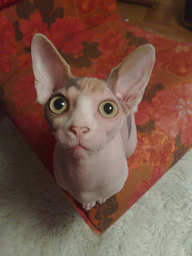

In [5]:
im = Image.open(path/'images'/'Sphynx_185.jpg')
im.to_thumb(256)

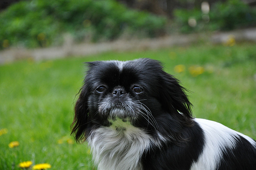

In [6]:
im = Image.open(path/'images'/'japanese_chin_111.jpg')
im.to_thumb(256)

So `./images` contains 7393 images of pets, where the breed is in the file name. If the first letter is upper-case, it's a cat. If the first letter is lower-case, it's a dog.

In [7]:
(path/"annotations").ls()

(#7) [Path('annotations/test.txt'),Path('annotations/._trimaps'),Path('annotations/README'),Path('annotations/list.txt'),Path('annotations/trainval.txt'),Path('annotations/xmls'),Path('annotations/trimaps')]

## Build a datablock

In [8]:
get_pet_label = lambda s: re.findall(r'(.+)_\d+\.jpg$', s.name)[0]

In [9]:
get_pet_label((path/'images').ls()[1])

'japanese_chin'

In [10]:
pets = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # the independent and dependent variable types
    get_items=get_image_files, # how to get a list of image files -- in this case from folders in the path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # how to partition the data into training/validation sets
    get_y=get_pet_label, # how to get the target -- in this case from a regular expression
    # alternatively:
    #get_y=using_attr(RegexLabeller(r'(.+)_\d+\.jpg$'), 'name'),
    item_tfms=Resize(460), # transformations to apply to the data before handing to the GPU
    batch_tfms=aug_transforms(size=224, min_scale=0.75) # transformations to apply to the data after handing to the GPU. Data augmentation.
)

### Aside: Presizing

`item_tfms=Resize(460)` resizes the image to quite a large random square image (460x460). `batch_tfms=...` uses `RandomResizeCrop` in the `size=224` argument to output an augmented square image which is 224x224.

The first step is used so that the image augmentation can take place on the GPU.

Fastai's implementation of image augmentation is also performed in a less lossy way, by applying the desired transformations only once, and then interpolated only once. Most other deep learning libraries perform interpolation at each step of the augmentation, which damages image quality.

In [11]:
dls = pets.dataloaders(path/'images')

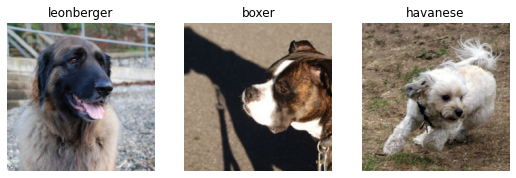

In [12]:
dls.valid.show_batch(nrows=1, ncols=3)

To inspect the image augmentation:

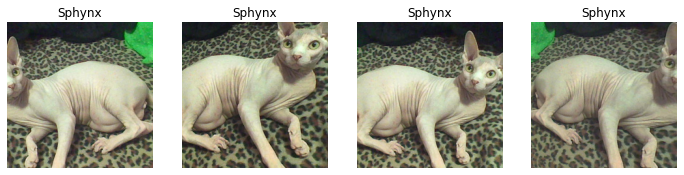

In [13]:
dls.show_batch(nrows=1, ncols=4, unique=True)

In [14]:
# # This line will print out progress in building the DataBlock. Useful for debugging.
# pets.summary(path/'images')

Tip: Instead of spending loads of time data cleaning, build a model as soon as you have a `dataloaders`. A model will help understand where the data are dirty.

In [15]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.518563,0.339702,0.110284,00:56


epoch,train_loss,valid_loss,error_rate,time
0,0.490152,0.327763,0.106225,00:41
1,0.306663,0.242832,0.081191,00:42


In [16]:
interp = ClassificationInterpretation.from_learner(learn)

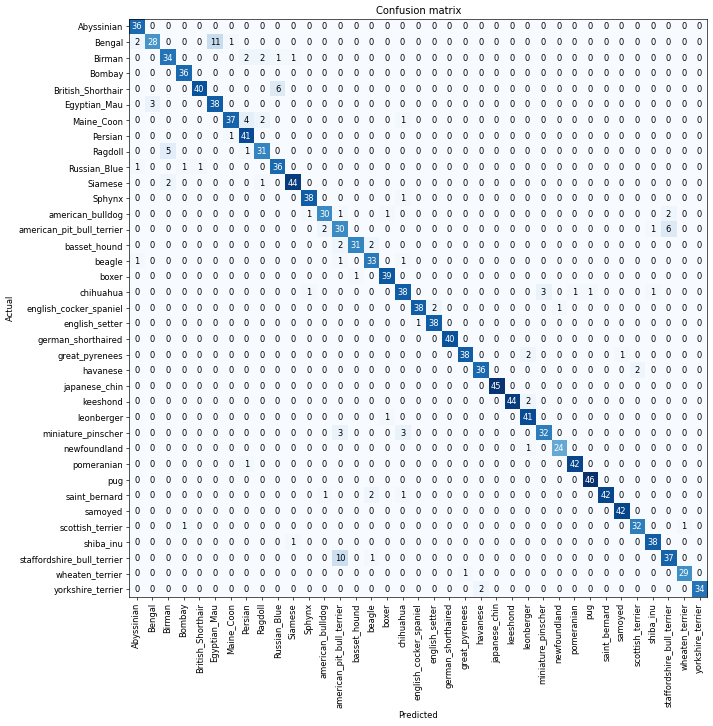

In [17]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

We can get the most confused classes with this:

In [24]:
interp.most_confused(min_val=5)

[('Bengal', 'Egyptian_Mau', 11),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 10),
 ('British_Shorthair', 'Russian_Blue', 6),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Ragdoll', 'Birman', 5)]

These are largely sensible mistakes to make

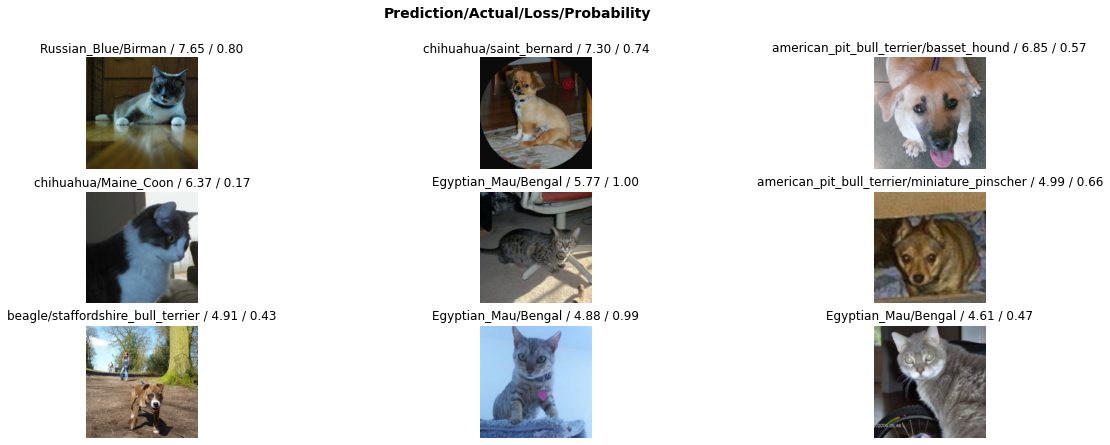

In [18]:
interp.plot_top_losses(9, nrows=3, ncols=3, figsize=(20,7))

The loss function fastai decided to use was:

In [20]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

## Aside: Softmax, Negative Log Likelihood and Cross Entropy

Consider a neural network with 3 activations in the final layer, e.g.

In [21]:
acts = torch.randn((6,3))*2  # activations

In [22]:
acts

tensor([[ 1.7275,  2.9100,  0.0697],
        [-3.5405,  2.3619,  3.3812],
        [-1.0636, -3.0229,  2.7706],
        [ 0.4199,  0.8443,  0.4454],
        [ 1.2492, -0.2921,  2.0771],
        [-1.2909,  1.0964, -1.6134]])

We can normalize these activations such that the class categories sum to 1 using a softmax function

In [39]:
sm_acts = torch.softmax(acts, dim=1)

In [40]:
sm_acts

tensor([[2.2456e-01, 7.3265e-01, 4.2792e-02],
        [7.2414e-04, 2.6497e-01, 7.3431e-01],
        [2.1097e-02, 2.9740e-03, 9.7593e-01],
        [2.8134e-01, 4.3007e-01, 2.8860e-01],
        [2.8551e-01, 6.1124e-02, 6.5337e-01],
        [7.9311e-02, 8.6324e-01, 5.7449e-02]])

In [41]:
sm_acts.sum(dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

The advantage of using a softmax in classification is that the use of exponential functions results in the output being very sensitive to the activations, so the model will tend to pick just one class as the prediction.

Say that the target (i.e. the corresponding data labels for each activation) is the following tensor

In [25]:
targ = tensor([2,0,1,1,2,0])  # known labels from training data

The negative log likelihood is simply (-1) times the predicted (log) probability of the true label. The (-1) is because we want to minimize this value

In [26]:
idx = range(len(targ))

In [42]:
-sm_acts[idx, targ]

tensor([-0.0428, -0.0007, -0.0030, -0.4301, -0.6534, -0.0793])

In [43]:
F.nll_loss(sm_acts, targ, reduction='none')  # nll_loss doesn't actually do a log, for computational reasons, see below

tensor([-0.0428, -0.0007, -0.0030, -0.4301, -0.6534, -0.0793])

Mathematically, the NLL is the (mean of the) log probabilities of the data class (times -1)

<img src="./figures/nll.png" style="width:700px"> 

`reduction` in `nll_loss` allows you to choose other kinds of summaries of the negative log likelihood, besides the mean. The picture above uses a sum. `reduction='none'` shows the NLL for all the data examples.

In PyTorch, `nll_loss` doesn't actually implement the log itself -- it assumes that the activations have already been passed through a softmax. This confusing name is because PyTorch has a fast, accurate, implementation of `log(softmax(x))` called `log_softmax`. So `nll_loss` is designed to be used after `log_softmax`. So `nll_loss` doesn't actually compute NLL!

The combination `NLL(log(softmax(x)), target)` is called the [**cross-entropy loss**](https://en.wikipedia.org/wiki/Cross_entropy), and is a sensitive, smooth, loss function appropriate for classification.

In [30]:
nn.CrossEntropyLoss(reduction='none')(acts, targ)

tensor([3.1514, 7.2305, 5.8178, 0.8438, 0.4256, 2.5344])

In [52]:
-sm_acts[idx, targ].log()

tensor([3.1514, 7.2305, 5.8178, 0.8438, 0.4256, 2.5344])

In [50]:
F.nll_loss(F.log_softmax(acts, dim=1), targ, reduction='none')

tensor([3.1514, 7.2305, 5.8178, 0.8438, 0.4256, 2.5344])

## Improving the model

We can use the _learning rate finder_ to optimize our learning rate. This works by beginning with a very small learning rate, and gradually increasing `lr` with each mini-batch until the loss begins to increase with each iteration. The algorithm then stops, the network parameters are reset to the weights as they were before running the learning rate finder, and a human can then choose a learning rate which seems optimal.  E.g. `lr` which is a bit lower than the minimum of the generated function.

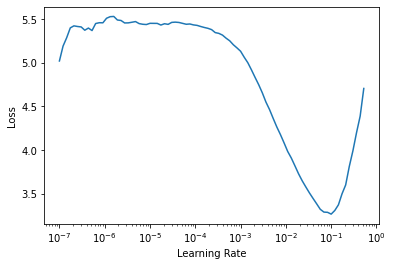

In [25]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
lr_min, lr_steep = learn.lr_find()

So notice how the loss is generally decreasing with each iteration until `lr=0.1`, where it starts to increase. We certainly **do not** want the minimum of this function for our learning rate because, with the mini-batch which has the minimum loss, the loss didn't improve with that particular mini-batch: it remained flat. So it is certainly the case that the minimum of this curve is too large a learning rate.

`lr_min` is the minimum of the above curve /10, and `lr_steep` is the steepest descending point on the curve. The steepest point on the curve is often a good choice because that is where the loss was reducing the fastest -- although it's worth keeping in mind that the function above changes every time you run `lr_find()` because it depends on the exact data which are being passed through the algorithm. In practice, we often find that the minimum/10 often works very well too.

In [27]:
print(f'Minimum/10: {lr_min:.2e}', f'Steepest point: {lr_steep:.2e}')

Minimum/10: 1.00e-02 Steepest point: 3.02e-03


In [28]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.273488,0.354410,0.114344,00:35


epoch,train_loss,valid_loss,error_rate,time
0,0.522169,0.367533,0.116373,00:42
1,0.310648,0.251037,0.081867,00:42


In this case the performance isn't too different to the default learning rate for fastai, which is `2e-3`.

### Unfreezing and transfer learning

`fine_tune` only trains the head of the network (head being the final, or last few, layers of a network). Once the head is trained, we can also train the rest of the network by unfreezing the model.

In [30]:
learn.unfreeze()

SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=9.12010818865383e-07)

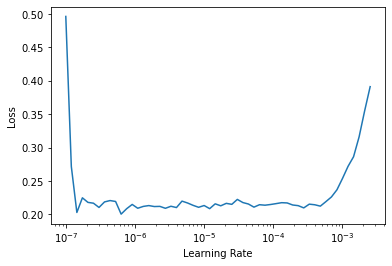

In [31]:
learn.lr_find()

With plots of this form, we tend to find where the model is starting to get worse -- here it's about `1e-4` -- and then go a factor of 10 below that, so about `1e-5` in this case

In [32]:
learn.fit_one_cycle(6, lr_max=1e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.205607,0.239471,0.077808,00:41
1,0.198015,0.220510,0.069012,00:42
2,0.162205,0.215450,0.068336,00:41
3,0.146279,0.211831,0.073072,00:42
4,0.143911,0.212609,0.072395,00:42
5,0.130318,0.213760,0.071042,00:43


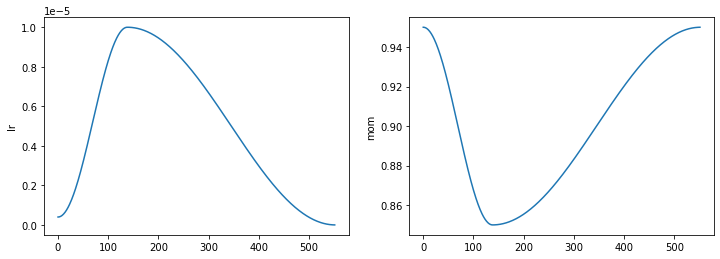

In [34]:
learn.recorder.plot_sched()

You can see from this plot that we don't actually use a single learning rate. `lr_max=1e-5` means the maximum learning rate we use is `1e-5`, but we have a waveform which looks a bit like a ramp. This helps the model get out of local minima. This idea was found by Leslie Smith in 2015 in [this paper](https://arxiv.org/pdf/1506.01186.pdf).

We also have a waveform for the momentum of the optimizer such that when we take large steps, we have smaller momentum -- so we don't get too carried away and jump out of a large valley.

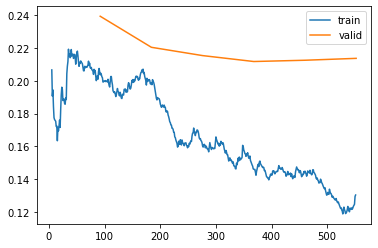

In [33]:
learn.recorder.plot_loss()

The `error_rate` seems to have flattened out. We need to try something else.

### Discriminative learning rates

The approach above trains the whole network using the same learning rate parameters. But this doesn't make much sense: the earliest layers of the network are likely to not need much work -- they are simple features like edge detectors etc. In contrast, the final (few) layer(s) were initialised randomly, and therefore need the most work. We need a means to use a range of learning rates across the network, with smaller rates for the earliest layers, and larger rates for the final layers.

Let's try training the model again, but this time use discriminative learning rates when we unfreeze the model.

In [35]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3, base_lr=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.284149,0.351920,0.109608,00:34


epoch,train_loss,valid_loss,error_rate,time
0,0.495225,0.413632,0.117050,00:41
1,0.380596,0.306034,0.091340,00:42
2,0.215389,0.236500,0.070365,00:42


SuggestedLRs(lr_min=2.0892961401841602e-06, lr_steep=9.12010818865383e-07)

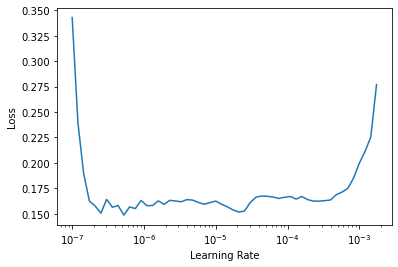

In [36]:
learn.unfreeze()
learn.lr_find()

So the minimum again looks like it's at `2e-4`, so let's take a slice of learning rates centred at `1e-5`.

In [37]:
learn.fit_one_cycle(12, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.148883,0.232481,0.068336,00:41
1,0.147333,0.227102,0.064276,00:42
2,0.136379,0.227779,0.064953,00:42
3,0.112539,0.230222,0.066306,00:42
4,0.099604,0.230467,0.071719,00:42
5,0.094977,0.231363,0.065629,00:42
6,0.077429,0.227024,0.069012,00:42
7,0.080962,0.214764,0.062246,00:42
8,0.066938,0.218000,0.062246,00:42
9,0.071672,0.216510,0.062246,00:42


In [39]:
learn.save('stage-2');

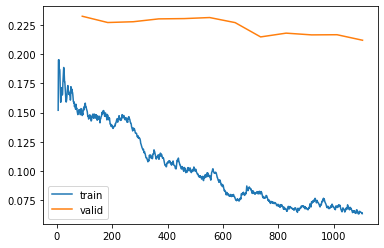

In [40]:
learn.recorder.plot_loss()

Still going down, let's try a few more epochs

In [47]:
learn.load('stage-2');

In [48]:
learn.fit_one_cycle(5, lr_max=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.065224,0.219782,0.060893,00:42
1,0.066291,0.228629,0.064276,00:42
2,0.058636,0.222195,0.061570,00:43
3,0.062070,0.229729,0.062923,00:42
4,0.056401,0.225912,0.063599,00:43


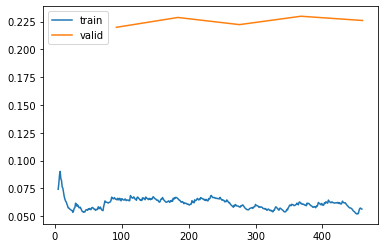

In [49]:
learn.recorder.plot_loss()

Not really helping, we need to try something else.

### Deeper architectures

We can have more layers in an attempt to get a better accuracy. Bigger models means more parameters. This can sometimes mean that you get a GPU error which looks like

```
Cuda runtime error: out of memory
```

Tricks:

- Use mixed precision training, where you use less precise numbers where possible using training. Do this, use code like:

```python
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
```

- Use smaller batch sizes

In [50]:
learn = cnn_learner(dls, resnet50, metrics=error_rate) # use full precision, see how it goes
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/jupyter/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.235264,0.326331,0.102842,00:56
1,0.595060,0.313299,0.100135,00:54
2,0.444928,0.275195,0.086604,00:54


epoch,train_loss,valid_loss,error_rate,time
0,0.267269,0.259924,0.083221,01:11
1,0.295169,0.338954,0.099459,01:10
2,0.248694,0.337100,0.089986,01:10
3,0.147586,0.247142,0.073072,01:10
4,0.086055,0.234827,0.066982,01:10
5,0.062145,0.231308,0.063599,01:11


We've gone back to `fine_tune` again for convenience. We can pass `freeze_epochs` to tell fastai how many epochs to train while frozen. It will automatically change learning rates appropriately for most datasets.

In this case, it looks like a bigger model doesn't particularly help -- which is useful to know. Bigger models don't necessarily mean better performance, so it's important to try smaller models before scaling up.